In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import random

2024-12-09 13:20:51.271952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 13:20:51.272097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 13:20:51.443758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
IMGS = 500

TEST_PATH = '/kaggle/input/tusimple-preprocessed/tusimple_preprocessed/training/frames'
TEST_MASKS_PATH = '/kaggle/input/tusimple-preprocessed/tusimple_preprocessed/training/lane-masks'

test_image_files = os.listdir(TEST_PATH)
test_mask_files = os.listdir(TEST_MASKS_PATH)

X_test = np.zeros((IMGS, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((IMGS, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

test = []
test_masks = []
for n, image_file in enumerate(test_image_files):
    if os.path.splitext(image_file)[1].lower() == ".jpg" and n < IMGS:
      image_path = os.path.join(TEST_PATH, image_file)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (256,256))
      image = image / 255

      test.append(image)

mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
for n, mask_file in enumerate(test_mask_files):
    if os.path.splitext(mask_file)[1].lower() == ".jpg" and n < IMGS:
      mask_path = os.path.join(TEST_MASKS_PATH, mask_file)
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, (256,256))
      mask = mask / 255.0  # Normalize to [0, 1]

      test_masks.append(np.expand_dims(mask, axis=-1))

X_test, Y_test = np.array(test), np.array(test_masks)

for i in range(len(Y_test)):
    Y_test[i][Y_test[i] < 0.5] = 0
    Y_test[i][Y_test[i] >= 0.5] = 1
print(np.unique(Y_test[5]))

[0. 1.]


In [14]:
import pandas as pd

models = ['/kaggle/input/unet/tensorflow2/default/1/model_unet.keras',
          '/kaggle/input/unet/tensorflow2/default/1/model_unet_att.keras',
          '/kaggle/input/unet/tensorflow2/default/1/model_unet_aug_att.keras',
          '/kaggle/input/unet/tensorflow2/default/1/model_unet_resnet50_unet_aug.keras',
          '/kaggle/input/unet/tensorflow2/default/1/model_unet_resnet50_unet_fixed.keras',
          '/kaggle/input/unet/tensorflow2/default/1/model_unet_resnet50_unet_fixed_att_conv2d.keras',
          '/kaggle/input/unet/tensorflow2/default/1/model_unet_resnet50_unet_fixed_aug_att_conv2d.keras',
          '/kaggle/input/unet_aug/tensorflow2/default/1/model_unet_aug_att_without_rot90.keras',
          '/kaggle/input/unet_aug/tensorflow2/default/1/model_unet_resnet_aug_att_without_rot90.keras']


df = pd.DataFrame(index=['Precision score', 'Recall Score', 'Accuracy Score', 'Dice Score', 'Intersection Over Union', 'F1 score'])


def precision_score(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)


def accuracy(groundtruth_mask, pred_mask):
    correct = np.sum(groundtruth_mask == pred_mask)
    total = groundtruth_mask.size
    acc = correct / total
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3)

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

def f1_score(precision,recall):
    f1_score = 2 * (precision * recall) / (precision + recall)
    return round(f1_score, 3)



for model in models:
    model_name = os.path.basename(model)

    print(f"Evaluating model: {model_name}")
    model = load_model(model)

    y_pred = model.predict(X_test)
    print("prediction done")
    print(y_pred.shape)

    print(len(np.unique(y_pred[5])))
    for i in range(len(y_pred)):
        y_pred[i][y_pred[i] < 0.5] = 0
        y_pred[i][y_pred[i] >= 0.5] = 1
    print(np.unique(y_pred[5]))

   
    pre_score = 0
    rec_score = 0
    acc = 0
    dice_c = 0
    io_u = 0
    f1_total = 0
    
    #dictionary to store all scores and corresponding images
    corresponding_images = {
        "precision": [],
        "recall": [],
        "accuracy": [],
        "dice_coef": [],
        "iou": [],
        "f1_score": [],
    }
    
    for num in range(len(y_pred)):
        y_true_flat = Y_test[num].flatten()
        y_pred_flat = y_pred[num].flatten()
    
        pre = precision_score(y_true_flat, y_pred_flat)
        rec = recall_score(y_true_flat, y_pred_flat)
        acc_img = accuracy(y_true_flat, y_pred_flat)
        dice = dice_coef(y_true_flat, y_pred_flat)
        iou_img = iou(y_true_flat, y_pred_flat)
        f1 = 2 * (pre * rec) / (pre + rec) if (pre + rec) > 0 else 0
    
        corresponding_images["precision"].append((pre, num))
        corresponding_images["recall"].append((rec, num))
        corresponding_images["accuracy"].append((acc_img, num))
        corresponding_images["dice_coef"].append((dice, num))
        corresponding_images["iou"].append((iou_img, num))
        corresponding_images["f1_score"].append((f1, num))
    
        pre_score += pre
        rec_score += rec
        acc += acc_img
        dice_c += dice
        io_u += iou_img
        f1_total += f1
    
    pre_score = round(pre_score / len(y_pred), 3)
    rec_score = round(rec_score / len(y_pred), 3)
    acc = round(acc / len(y_pred), 3)
    dice_c = round(dice_c / len(y_pred), 3)
    io_u = round(io_u / len(y_pred), 3)
    f1_avg = round(f1_total / len(y_pred), 3)
        
    print("\nAverage Scores:")
    print("Precision (Avg):", pre_score)
    print("Recall (Avg):", rec_score)
    print("Accuracy (Avg):", acc)
    print("Dice Coefficient (Avg):", dice_c)
    print("IoU (Avg):", io_u)
    print("F1 Score (Avg):", f1_avg)


    df[model_name] = [pre_score, rec_score, acc, dice_c, io_u, f1_avg]

df.to_csv('model_eval_500.csv')

df

Evaluating model: model_unet.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
prediction done
(500, 256, 256, 1)
60050
[0. 1.]

Average Scores:
Precision (Avg): 0.791
Recall (Avg): 0.757
Accuracy (Avg): 0.981
Dice Coefficient (Avg): 0.772
IoU (Avg): 0.634
F1 Score (Avg): 0.772
Evaluating model: model_unet_att.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
prediction done
(500, 256, 256, 1)
64724
[0. 1.]

Average Scores:
Precision (Avg): 0.801
Recall (Avg): 0.77
Accuracy (Avg): 0.982
Dice Coefficient (Avg): 0.784
IoU (Avg): 0.65
F1 Score (Avg): 0.784
Evaluating model: model_unet_aug_att.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
prediction done
(500, 256, 256, 1)
65378
[0. 1.]

Average Scores:
Precision (Avg): 0.728
Recall (Avg): 0.654
Accuracy (Avg): 0.974
Dice Coefficient (Avg): 0.684
IoU (Avg): 0.528
F1 Score (Avg): 0.684
Evaluating model: model_unet_resnet50_unet_aug.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step
prediction done
(500, 256, 256, 1)
65296
[0. 1.]

Average Scores:
Prec

,model_unet.keras,model_unet_att.keras,model_unet_aug_att.keras,model_unet_resnet50_unet_aug.keras,model_unet_resnet50_unet_fixed.keras,model_unet_resnet50_unet_fixed_att_conv2d.keras,model_unet_resnet50_unet_fixed_aug_att_conv2d.keras,model_unet_aug_att_without_rot90.keras,model_unet_resnet_aug_att_without_rot90.keras
Precision score,0.791,0.801,0.728,0.780,0.828,0.821,0.780,0.793,0.831
Recall Score,0.757,0.770,0.654,0.664,0.769,0.803,0.741,0.781,0.773
Accuracy Score,0.981,0.982,0.974,0.977,0.983,0.984,0.980,0.982,0.983
Dice Score,0.772,0.784,0.684,0.713,0.796,0.811,0.758,0.786,0.800
Intersection Over Union,0.634,0.650,0.528,0.562,0.666,0.686,0.618,0.653,0.672
F1 score,0.772,0.784,0.684,0.713,0.796,0.811,0.758,0.786,0.800


In [16]:
dice_min = min(corresponding_images["dice_coef"], key=lambda x: x[0])
print(f"Minimum Dice Coefficient: {dice_min[0]}, Image Index: {dice_min[1]}")

dice_max = max(corresponding_images["dice_coef"], key=lambda x: x[0])
print(f"Maximum Dice Coefficient: {dice_max[0]}, Image Index: {dice_max[1]}")

dice_values = [item[0] for item in corresponding_images["dice_coef"]]  #dice values
dice_avg = sum(dice_values) / len(dice_values)
print(f"Average Dice Coefficient: {dice_avg:.3f}")

Minimum Dice Coefficient: 0.471, Image Index: 88
Maximum Dice Coefficient: 0.923, Image Index: 245
Average Dice Coefficient: 0.800


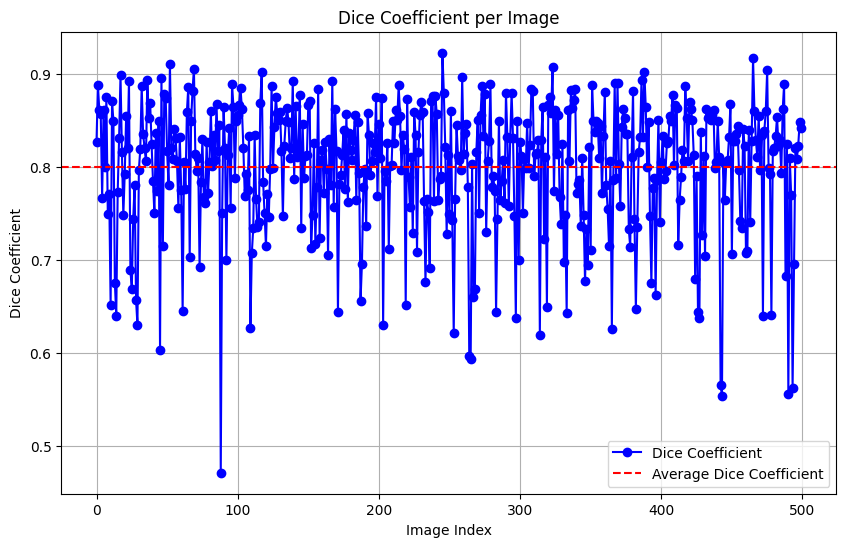

In [15]:
import matplotlib.pyplot as plt

dice_values = [item[0] for item in corresponding_images["dice_coef"]]
image_indices = [item[1] for item in corresponding_images["dice_coef"]]

plt.figure(figsize=(10, 6))
plt.plot(image_indices, dice_values, marker='o', linestyle='-', color='b', label='Dice Coefficient')

plt.xlabel("Image Index")
plt.ylabel("Dice Coefficient")
plt.title("Dice Coefficient per Image")
plt.axhline(y=sum(dice_values)/len(dice_values), color='r', linestyle='--', label='Average Dice Coefficient')  #average line
plt.legend()
plt.grid(True)

plt.show()

selected_indices:   [123, 245, 88]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


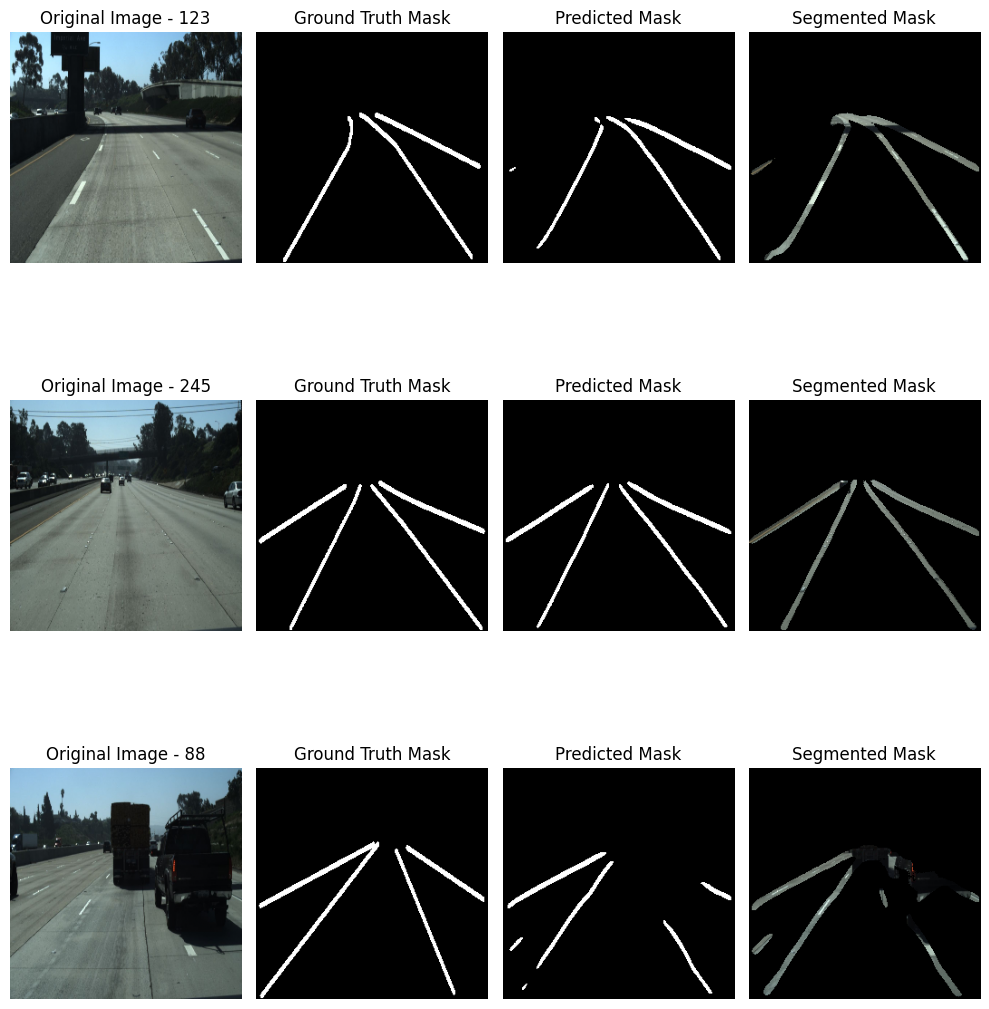

In [19]:
num_samples = 3  # Adjust the number of samples to visualize

selected_indices = [123, 245, 88]

fig, axes = plt.subplots(num_samples, 4, figsize=(10, 4*num_samples))


for i, idx in enumerate(selected_indices):
    # original image
    axes[i, 0].imshow(X_test[idx])
    axes[i, 0].set_title(f"Original Image - {idx}")
    axes[i, 0].axis('off')

    # ground truth mask
    axes[i, 1].imshow(Y_test[idx].squeeze(), cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis('off')

    # predicted mask
    axes[i, 2].imshow(y_pred[idx].squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')
    
    # segmented mask
    y_pred_2 = model.predict(np.expand_dims(X_test[idx],axis=0))
    segmented = np.squeeze(X_test[idx]).copy()
    segmented[np.squeeze(y_pred_2)<0.2] = 0
    axes[i, 3].imshow(segmented, cmap='gray')
    axes[i, 3].set_title("Segmented Mask")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()